In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_sleep_data(file_path='filled-data.csv'):
    data = pd.read_csv(file_path)

    # Clean percentage columns: remove % and convert to float
    percentage_cols = ['%deep duration', '%wake duration', '%restlessness']
    for col in percentage_cols:
        if col in data.columns:
            data[col] = data[col].astype(str).str.replace('%', '').astype(float)
            
    interventions = ['Baseline', 'Avoid Screen Time', 'Breathing']
    grouped_data = {intervention: data[data['Intervention'] == intervention] for intervention in interventions}

    print("\n===== DATA COMPLETENESS ANALYSIS =====")
    variables = [
        'manual restless score', 'sleep score', 'total sleep duration', 
        '%deep duration', '%wake duration', 'restlessness%',
        'start & end controlled?', 'caffeine amount controlled?', 'calories intake controlled?', 'activity level controlled?'
    ]

    var_labels = [
        'Manual Restless Score', 'Sleep Score', 'Total Sleep Duration',
        '% Deep Sleep', '% Wake Duration', '% Restlessness',
        'Sleep Schedule Controlled', 'Caffeine Controlled', 'Calories Controlled', 'Activity Controlled'
    ]

    completeness = pd.DataFrame(index=['Baseline', 'Avoid Screen Time', 'Breathing', 'Overall'],
                                 columns=['Expected Days'] + var_labels)

    for intervention in interventions:
        subset = grouped_data[intervention]
        completeness.loc[intervention, 'Expected Days'] = len(subset)
        for var, label in zip(variables, var_labels):
            total = len(subset)
            available = subset[var].notna().sum()
            completeness.loc[intervention, label] = f"{available}/{total} ({round(available/total*100)}%)"

    total_data = data
    completeness.loc['Overall', 'Expected Days'] = len(total_data)
    for var, label in zip(variables, var_labels):
        available = total_data[var].notna().sum()
        completeness.loc['Overall', label] = f"{available}/{len(total_data)} ({round(available/len(total_data)*100)}%)"

    print(completeness)

    def get_descriptive_stats(variable):
        stats_df = pd.DataFrame(index=interventions, columns=['n', 'Mean', 'Median', 'Min', 'Max', 'SD'])
        for intervention in interventions:
            vals = grouped_data[intervention][variable].dropna()
            stats_df.loc[intervention] = [
                len(vals),
                round(vals.mean(), 2) if not vals.empty else np.nan,
                round(vals.median(), 2) if not vals.empty else np.nan,
                round(vals.min(), 2) if not vals.empty else np.nan,
                round(vals.max(), 2) if not vals.empty else np.nan,
                round(vals.std(), 2) if not vals.empty else np.nan,
            ]
        return stats_df

    print("\n===== DESCRIPTIVE STATISTICS =====")

    restless_stats = get_descriptive_stats('manual restless score')
    sleep_score_stats = get_descriptive_stats('sleep score')
    sleep_duration_stats = get_descriptive_stats('total sleep duration')
    deep_percentage_stats = get_descriptive_stats('%deep duration')
    awake_percentage_stats = get_descriptive_stats('%wake duration')
    restless_percentage_stats = get_descriptive_stats('restlessness%')

    print("\n----- Manual Restless Score -----\n", restless_stats)
    print("\n----- Sleep Score -----\n", sleep_score_stats)
    print("\n----- Total Sleep Duration (minutes) -----\n", sleep_duration_stats)
    print("\n----- % Deep Sleep Duration -----\n", deep_percentage_stats)
    print("\n----- % Wake Duration -----\n", awake_percentage_stats)
    print("\n----- % Restlessness Duration -----\n", restless_percentage_stats)

    print("\n===== ADHERENCE ANALYSIS =====")
    adherence_vars = ['start & end controlled?', 'caffeine amount controlled?', 'calories intake controlled?', 'activity level controlled?']
    adherence_labels = ['Sleep Schedule', 'Caffeine', 'Calories', 'Activity']

    adherence_stats = pd.DataFrame(index=interventions, columns=adherence_labels)

    for intervention in interventions:
        subset = grouped_data[intervention]
        for var, label in zip(adherence_vars, adherence_labels):
            available = subset[var].dropna()
            if len(available) > 0:
                adherence_rate = (available.sum() / len(available)) * 100
                adherence_stats.loc[intervention, label] = f"{available.sum()}/{len(available)} ({round(adherence_rate,1)}%)"
            else:
                adherence_stats.loc[intervention, label] = "No Data"

    print(adherence_stats)

    print("\n===== STATISTICAL TESTS (Manual Restless Score) =====")
    def run_ttest(x, y):
        return stats.ttest_ind(x, y, equal_var=False)

    baseline = grouped_data['Baseline']['manual restless score'].dropna()
    screen = grouped_data['Avoid Screen Time']['manual restless score'].dropna()
    breathing = grouped_data['Breathing']['manual restless score'].dropna()

    tests = pd.DataFrame(index=['Baseline vs Screen', 'Baseline vs Breathing', 'Screen vs Breathing'],
                         columns=['t-statistic', 'p-value'])

    t1 = run_ttest(baseline, screen)
    t2 = run_ttest(baseline, breathing)
    t3 = run_ttest(screen, breathing)

    tests.loc['Baseline vs Screen'] = [round(t1.statistic, 2), round(t1.pvalue, 3)]
    tests.loc['Baseline vs Breathing'] = [round(t2.statistic, 2), round(t2.pvalue, 3)]
    tests.loc['Screen vs Breathing'] = [round(t3.statistic, 2), round(t3.pvalue, 3)]

    print(tests)

    with pd.ExcelWriter('sleep_study_analysis_final.xlsx') as writer:
        completeness.to_excel(writer, sheet_name='Data Completeness')
        restless_stats.to_excel(writer, sheet_name='Manual Restless Score Stats')
        sleep_score_stats.to_excel(writer, sheet_name='Sleep Score Stats')
        sleep_duration_stats.to_excel(writer, sheet_name='Sleep Duration Stats')
        deep_percentage_stats.to_excel(writer, sheet_name='% Deep Sleep Stats')
        awake_percentage_stats.to_excel(writer, sheet_name='% Wake Duration Stats')
        restless_percentage_stats.to_excel(writer, sheet_name='% Restlessness Stats')
        adherence_stats.to_excel(writer, sheet_name='Adherence Stats')
        tests.to_excel(writer, sheet_name='Statistical Tests')

    print("\nAll results saved to 'sleep_study_analysis_final.xlsx'")

if __name__ == "__main__":
    analyze_sleep_data('filled-data.csv')



===== DATA COMPLETENESS ANALYSIS =====
                  Expected Days Manual Restless Score  Sleep Score  \
Baseline                      7            7/7 (100%)    6/7 (86%)   
Avoid Screen Time            14          14/14 (100%)   7/14 (50%)   
Breathing                    14          14/14 (100%)  12/14 (86%)   
Overall                      35          35/35 (100%)  25/35 (71%)   

                  Total Sleep Duration  % Deep Sleep % Wake Duration  \
Baseline                    7/7 (100%)    7/7 (100%)      7/7 (100%)   
Avoid Screen Time         14/14 (100%)  14/14 (100%)    14/14 (100%)   
Breathing                  13/14 (93%)  14/14 (100%)    14/14 (100%)   
Overall                    34/35 (97%)  35/35 (100%)    35/35 (100%)   

                  % Restlessness Sleep Schedule Controlled  \
Baseline               6/7 (86%)                7/7 (100%)   
Avoid Screen Time     7/14 (50%)              14/14 (100%)   
Breathing            12/14 (86%)              14/14 (100%)   


Durbin-Watson statistic for Manual Restless Score: 0.059
⚠️  Positive autocorrelation detected (DW < 1.5). Consider smoothing.
Autocorrelation plot saved as 'autocorrelation_restless_score.png'
Lag relationship plot saved as 'lag_relationship_restless_score.png'

Autocorrelation coefficient: 0.85
R-squared of lag model: 0.72
Regression equation: Current = 0.69 + 0.83 × Previous

Applying Simple Moving Average (SMA) to handle autocorrelation:
Original vs. Smoothed (SMA with window=2):
    Original  Smoothed
0          7       NaN
1          8       7.5
2          7       7.5
3          6       6.5
4          9       7.5
5          7       8.0
6          6       6.5
7          6       6.0
8          8       7.0
9          8       8.0
10         6       7.0
11         6       6.0
12         5       5.5
13         5       5.0
14         4       4.5
15         4       4.0
16         3       3.5
17         5       4.0
18         4       4.5
19         3       3.5
20         1       2.0
21   

/var/folders/v8/1793d44577q9lqgx_01s8skm0000gn/T/ipykernel_61834/890133583.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.params[0], model.params[1]))


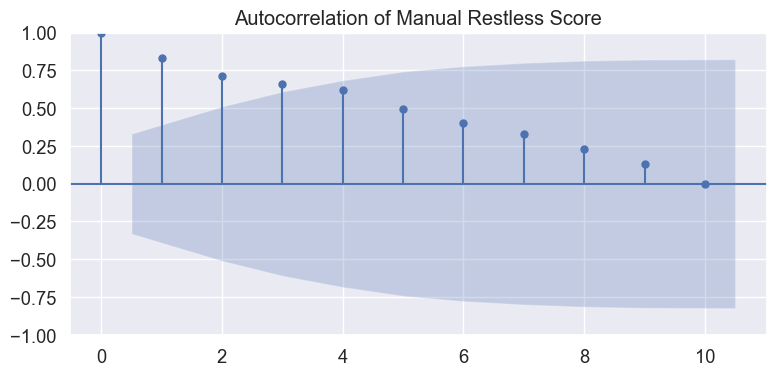

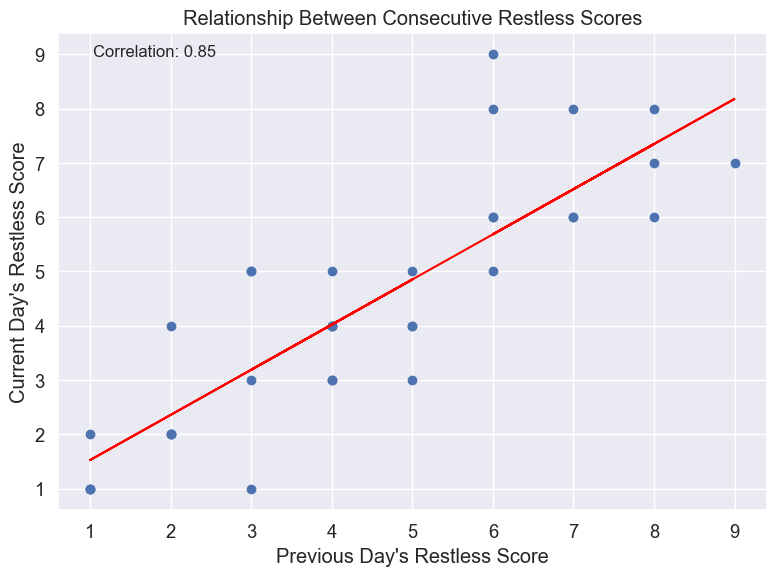

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

def check_autocorrelation(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    # Sort by date to ensure proper time order
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')
    
    # Check autocorrelation for Manual Restless Score
    restless_scores = data['manual restless score'].dropna()
    
    if len(restless_scores) < 3:
        print("Not enough data points to check autocorrelation")
        return
    
    # Calculate Durbin-Watson statistic (close to 2 means no autocorrelation)
    # Values significantly less than 2 indicate positive autocorrelation
    # Values significantly more than 2 indicate negative autocorrelation
    dw_stat = durbin_watson(restless_scores)
    print(f"Durbin-Watson statistic for Manual Restless Score: {dw_stat:.3f}")
    
    if dw_stat < 1.5:
        print("⚠️  Positive autocorrelation detected (DW < 1.5). Consider smoothing.")
    elif dw_stat > 2.5:
        print("⚠️  Negative autocorrelation detected (DW > 2.5). Consider further analysis.")
    else:
        print("✓ No significant autocorrelation detected.")
    
    # Create autocorrelation plot
    fig, ax = plt.figure(figsize=(8, 4)), plt.subplot(111)
    plot_acf(restless_scores, ax=ax, lags=10)
    plt.title('Autocorrelation of Manual Restless Score')
    plt.tight_layout()
    plt.savefig('autocorrelation_restless_score.png')
    print("Autocorrelation plot saved as 'autocorrelation_restless_score.png'")
    
    # Additional analysis if autocorrelation is detected
    if dw_stat < 1.5 or dw_stat > 2.5:
        # Create a lagged variable to visualize the relationship
        scores_series = pd.Series(restless_scores.values)
        lagged = pd.DataFrame({
            'Current': scores_series.iloc[1:].values,
            'Previous': scores_series.iloc[:-1].values
        })
        
        # Plot the relationship between current and previous values
        plt.figure(figsize=(8, 6))
        plt.scatter(lagged['Previous'], lagged['Current'])
        plt.xlabel('Previous Day\'s Restless Score')
        plt.ylabel('Current Day\'s Restless Score')
        plt.title('Relationship Between Consecutive Restless Scores')
        
        # Add regression line
        X = sm.add_constant(lagged['Previous'])
        model = sm.OLS(lagged['Current'], X).fit()
        plt.plot(lagged['Previous'], model.predict(X), color='red')
        
        # Add correlation coefficient
        corr = lagged['Current'].corr(lagged['Previous'])
        plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), 
                     xycoords='axes fraction', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('lag_relationship_restless_score.png')
        print("Lag relationship plot saved as 'lag_relationship_restless_score.png'")
        
        print(f"\nAutocorrelation coefficient: {corr:.2f}")
        print(f"R-squared of lag model: {model.rsquared:.2f}")
        print("Regression equation: Current = {:.2f} + {:.2f} × Previous".format(
            model.params[0], model.params[1]))
        
        # If significant autocorrelation, consider applying a simple moving average
        if abs(corr) > 0.3:
            print("\nApplying Simple Moving Average (SMA) to handle autocorrelation:")
            window = 2  # Can be adjusted based on the correlation pattern
            sma = scores_series.rolling(window=window, center=False).mean()
            
            print(f"Original vs. Smoothed (SMA with window={window}):")
            smoothed = pd.DataFrame({
                'Original': scores_series,
                'Smoothed': sma
            })
            print(smoothed)
            
            # Calculate Durbin-Watson statistic on smoothed data
            dw_smoothed = durbin_watson(sma.dropna())
            print(f"\nDurbin-Watson statistic after smoothing: {dw_smoothed:.3f}")
            
            if dw_smoothed < 1.5 or dw_smoothed > 2.5:
                print("⚠️  Autocorrelation still present after smoothing.")
            else:
                print("✓ Smoothing successfully addressed autocorrelation.")

if __name__ == "__main__":
    check_autocorrelation('filled-data.csv')

Initial Durbin-Watson statistic: 0.059
ACF and PACF plots saved as 'acf_pacf_analysis.png'

ARIMA Model Results:
                               SARIMAX Results                                
Dep. Variable:                  score   No. Observations:                   35
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -55.858
Date:                Sat, 26 Apr 2025   AIC                            121.715
Time:                        14:58:23   BIC                            129.492
Sample:                             0   HQIC                           124.400
                                 - 35                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.3659      1.475      3.637      0.000       2.475       8.257
avoid_screen

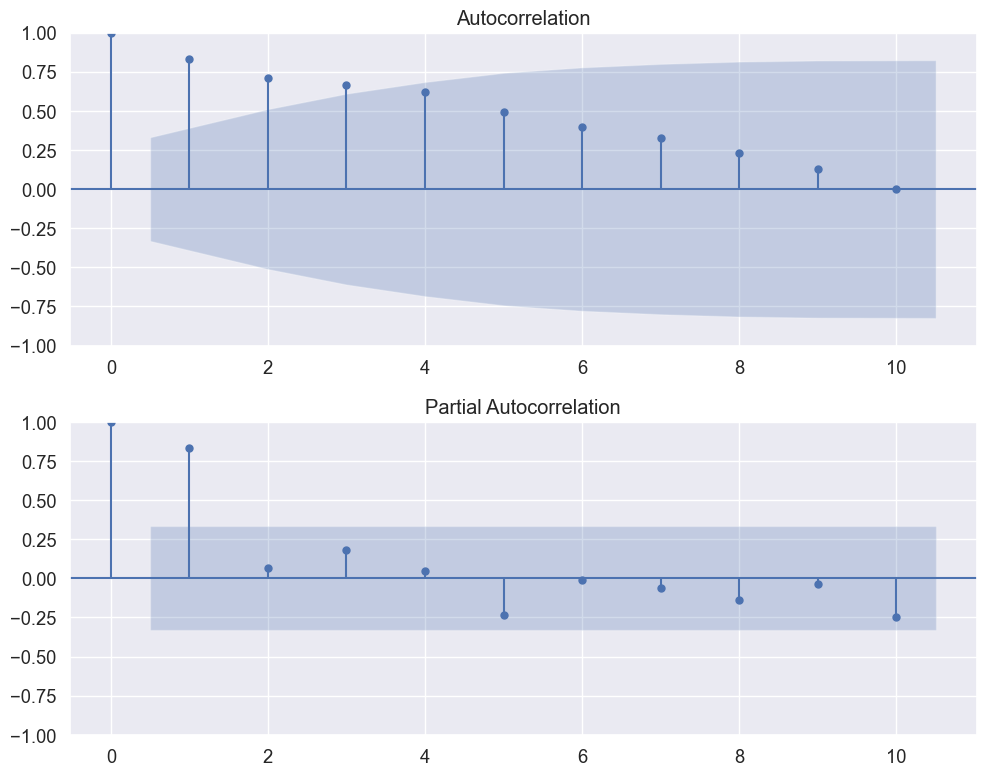

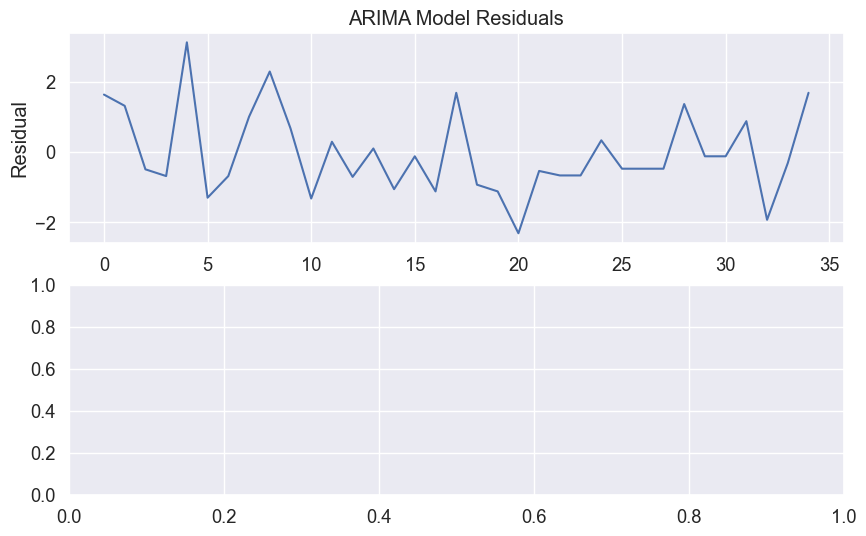

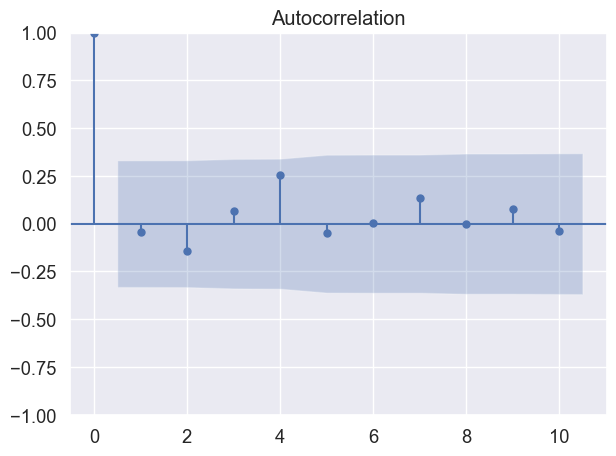

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

def handle_autocorrelation_properly(file_path):
    # Load and prepare data
    data = pd.read_csv(file_path)
    
    # Sort by date to ensure proper time order
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')
    
    # Extract restless scores
    restless_scores = data['manual restless score'].dropna()
    
    # Create a time series with intervention column
    ts_data = pd.DataFrame({
        'score': restless_scores.values,
        'intervention': data.loc[restless_scores.index, 'Intervention'].values
    })
    
    # Check initial autocorrelation
    dw_stat = durbin_watson(ts_data['score'])
    print(f"Initial Durbin-Watson statistic: {dw_stat:.3f}")
    
    # Plot ACF and PACF to determine ARIMA order
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(ts_data['score'], ax=ax1, lags=10)
    plot_pacf(ts_data['score'], ax=ax2, lags=10)
    plt.tight_layout()
    plt.savefig('acf_pacf_analysis.png')
    print("ACF and PACF plots saved as 'acf_pacf_analysis.png'")
    
    # Based on ACF/PACF pattern, determine ARIMA order
    # Typically for strong lag-1 autocorrelation, ARIMA(1,0,0) is appropriate
    
    # Create dummy variables for interventions
    ts_data['baseline'] = (ts_data['intervention'] == 'Baseline').astype(int)
    ts_data['avoid_screen'] = (ts_data['intervention'] == 'Avoid Screen Time').astype(int)
    ts_data['breathing'] = (ts_data['intervention'] == 'Breathing').astype(int)
    
    # Fit ARIMA model with exogenous variables (ARIMAX)
    # We'll use the intervention dummies as exogenous variables
    exog = ts_data[['avoid_screen', 'breathing']]  # baseline is reference
    
    # ARIMA(1,0,0) = AR(1) model
    model = ARIMA(ts_data['score'], exog=exog, order=(1, 0, 0))
    results = model.fit()
    
    print("\nARIMA Model Results:")
    print(results.summary())
    
    # Check residuals for autocorrelation
    residuals = results.resid
    dw_residuals = durbin_watson(residuals)
    print(f"\nDurbin-Watson statistic of ARIMA residuals: {dw_residuals:.3f}")
    
    if dw_residuals > 1.5 and dw_residuals < 2.5:
        print("✓ ARIMA model successfully addressed autocorrelation")
    else:
        print("⚠️ Autocorrelation may still be present in residuals")
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(residuals)
    plt.title('ARIMA Model Residuals')
    plt.ylabel('Residual')
    
    plt.subplot(2, 1, 2)
    plot_acf(residuals, lags=10)
    plt.tight_layout()
    plt.savefig('arima_residuals.png')
    print("Residual analysis plots saved as 'arima_residuals.png'")
    
    # Calculate intervention effects from ARIMA model
    print("\nIntervention Effects (ARIMA adjusted):")
    print(f"Avoid Screen Time effect: {results.params['avoid_screen']:.4f} (p-value: {results.pvalues['avoid_screen']:.4f})")
    print(f"Breathing effect: {results.params['breathing']:.4f} (p-value: {results.pvalues['breathing']:.4f})")
    
    # For comparison, calculate naive effects (ignoring autocorrelation)
    baseline_mean = ts_data.loc[ts_data['baseline'] == 1, 'score'].mean()
    avoid_screen_mean = ts_data.loc[ts_data['avoid_screen'] == 1, 'score'].mean()
    breathing_mean = ts_data.loc[ts_data['breathing'] == 1, 'score'].mean()
    
    print("\nNaive Mean Differences (ignoring autocorrelation):")
    print(f"Baseline mean: {baseline_mean:.4f}")
    print(f"Avoid Screen Time mean: {avoid_screen_mean:.4f} (diff: {avoid_screen_mean - baseline_mean:.4f})")
    print(f"Breathing mean: {breathing_mean:.4f} (diff: {breathing_mean - baseline_mean:.4f})")
    
    # Calculate effect sizes with confidence intervals
    from statsmodels.sandbox.stats.multicomp import multipletests
    
    # Get confidence intervals
    ci = results.conf_int()
    print("\nAdjusted 95% Confidence Intervals:")
    print(f"Avoid Screen Time: [{ci.loc['avoid_screen'][0]:.4f}, {ci.loc['avoid_screen'][1]:.4f}]")
    print(f"Breathing: [{ci.loc['breathing'][0]:.4f}, {ci.loc['breathing'][1]:.4f}]")
    
    return {
        'model_results': results,
        'arima_avoid_screen_effect': results.params['avoid_screen'],
        'arima_breathing_effect': results.params['breathing'],
        'arima_avoid_screen_pvalue': results.pvalues['avoid_screen'],
        'arima_breathing_pvalue': results.pvalues['breathing'],
        'naive_avoid_screen_effect': avoid_screen_mean - baseline_mean,
        'naive_breathing_effect': breathing_mean - baseline_mean,
        'durbin_watson_before': dw_stat,
        'durbin_watson_after': dw_residuals
    }

if __name__ == "__main__":
    results = handle_autocorrelation_properly('filled-data.csv')

Initial Durbin-Watson: 0.059
Durbin-Watson of Residuals: 1.962


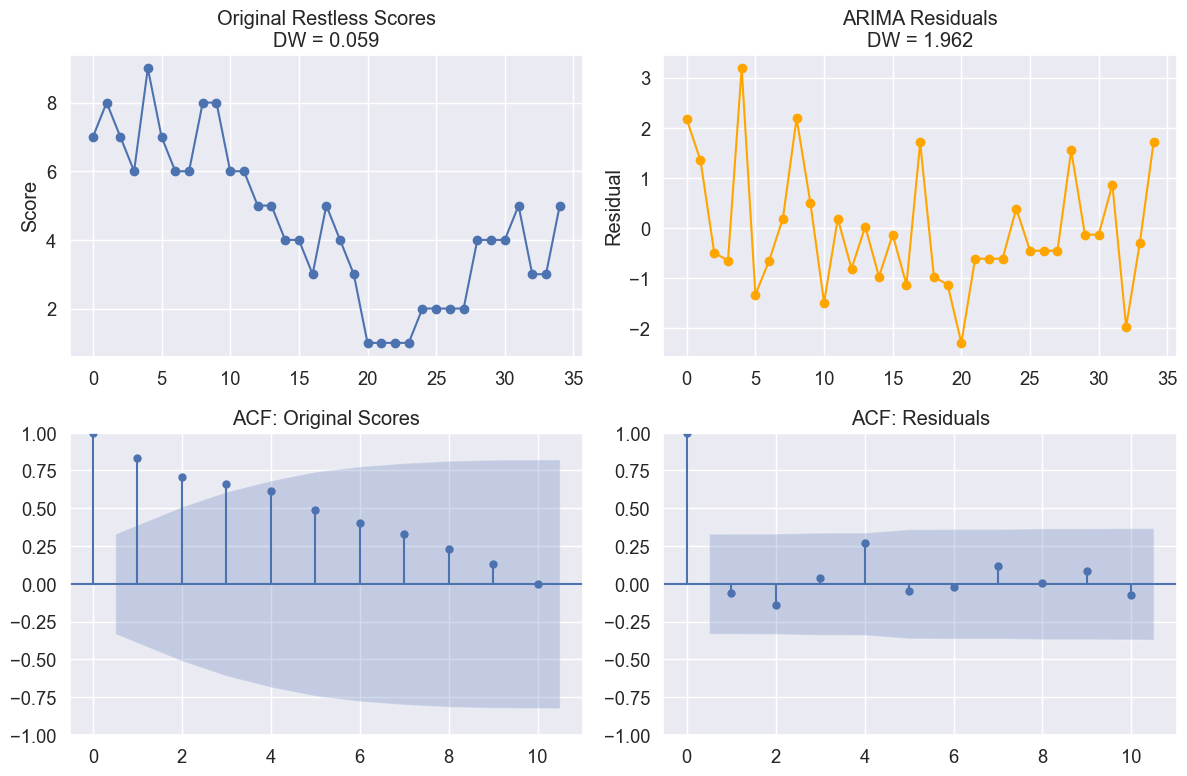

Plot saved as 'before_after_autocorrelation_fix.png'


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

# === Function to create the before vs after visualization ===
def plot_before_after_autocorrelation(file_path):
    # Load and sort the data
    data = pd.read_csv(file_path)
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')

    # Extract restless score
    restless_scores = data['manual restless score'].dropna()

    # Initial autocorrelation check
    dw_original = durbin_watson(restless_scores)
    print(f"Initial Durbin-Watson: {dw_original:.3f}")

    # Fit ARIMA(1,0,0)
    model = ARIMA(restless_scores, order=(1,0,0))
    results = model.fit()
    residuals = results.resid

    dw_residuals = durbin_watson(residuals)
    print(f"Durbin-Watson of Residuals: {dw_residuals:.3f}")

    # === Plot Original vs Residuals ===
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Time Series: Original
    axs[0,0].plot(restless_scores.values, marker='o')
    axs[0,0].set_title(f"Original Restless Scores\nDW = {dw_original:.3f}")
    axs[0,0].set_ylabel("Score")

    # Time Series: Residuals
    axs[0,1].plot(residuals.values, marker='o', color='orange')
    axs[0,1].set_title(f"ARIMA Residuals\nDW = {dw_residuals:.3f}")
    axs[0,1].set_ylabel("Residual")

    # ACF: Original
    plot_acf(restless_scores, lags=10, ax=axs[1,0])
    axs[1,0].set_title("ACF: Original Scores")

    # ACF: Residuals
    plot_acf(residuals, lags=10, ax=axs[1,1])
    axs[1,1].set_title("ACF: Residuals")

    plt.tight_layout()
    plt.savefig("before_after_autocorrelation_fix.png")
    plt.show()
    print("Plot saved as 'before_after_autocorrelation_fix.png'")

# === To Run It ===
if __name__ == "__main__":
    plot_before_after_autocorrelation('filled-data.csv')
